In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import polars as pl

fig_dir = "img/"
custom_cmap = plt.get_cmap("viridis")
plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_58154/2929325145.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# estimate energy consumption using the simple energest output
# Example energest output:
# [INFO: Energest  ] --- Period summary #2 (60 seconds)
# [INFO: Energest  ] Total time  :    1966080
# [INFO: Energest  ] CPU         :      10374/   1966080 (5 permil)
# [INFO: Energest  ] LPM         :    1955706/   1966080 (994 permil)
# [INFO: Energest  ] Deep LPM    :          0/   1966080 (0 permil)
# [INFO: Energest  ] Radio Tx    :        106/   1966080 (0 permil)
# [INFO: Energest  ] Radio Rx    :     104802/   1966080 (53 permil)
# [INFO: Energest  ] Radio total :     104908/   1966080 (53 permil)

# Energest ouput
energest_output = " --- Period summary #2 (60 seconds)\nTotal time  :    1966080\nCPU         :      10374/   1966080 (5 permil)\nLPM         :    1955706/   1966080 (994 permil)\nDeep LPM    :          0/   1966080 (0 permil)\nRadio Tx    :        106/   1966080 (0 permil)\nRadio Rx    :     104802/   1966080 (53 permil)\nRadio total :     104908/   1966080 (53 permil)"

# with regex, we can extract the numbers from the output
# total time
# CPU time
# LPM time
# Radio Tx time
# Radio Rx time
# Radio total time

# regex to extract the numbers
# regex = re.compile(r"Energest\s+]\s\D+\s+:\s+(\d+)")
summary_regex = re.compile(r"Period\s+summary\s+#[2-9]\s+\(\d+\s+seconds\)")
regex = re.compile(r":\s+(\d+)")

# extract the values
match = regex.findall(energest_output)
times = [int(x) for x in match]

print(times)

total_time, cpu_time, lpm_time, deep_lpm_time, radio_tx_time, radio_rx_time, radio_total_time = times

# print the values
print("Total time: %s" % total_time)
print("CPU time: %s" % cpu_time)
print("LPM time: %s" % lpm_time)
print("Deep LPM: %s" % deep_lpm_time)
print("Radio Tx time: %s" % radio_tx_time)
print("Radio Rx time: %s" % radio_rx_time)
print("Radio total time: %s" % radio_total_time)

# current draw in different states in mA
# CPU_CURRENT = 10
# LPM_CURRENT = 0.023
# DEEP_LPM_CURRENT = 0
# RADIO_TX_CURRENT = 18.4
# RADIO_RX_CURRENT = 17.4

CURRENT = {
    "CPU": 1.8, # mA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "LPM": 0.0051 + 0.021, # 26.1 uA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "DEEP_LPM": 0.0061, # 6.1 uA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "RADIO_RX": 18.8, # https://www.ti.com/lit/ds/symlink/cc2420.pdf?ts=1670166938154&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FCC2420
    "RADIO_TX": 17.4 # https://www.ti.com/lit/ds/symlink/cc2420.pdf?ts=1670166938154&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FCC2420
}

# 3 volt battery
VOLTAGE = 3

# We have the following values available
# []_time - the number of ticks spent in each mode
# TICKS_PER_SECOND - the number of ticks per second
# total_time - the total time in ticks
# []_CURRENT - the current draw in each mode
# voltage - the provided voltage to the component

# Equations
# state_avg_current_mA = ([]_time * current_mA) / total_time
# state_charge_mC = ([]_time * current_mA) / TICKS_PER_SECOND
# state_charge_mAh = state_charge_mC / 3600
# state_power_mW = avg_current_mA * voltage
# state_energy_mJ = state_charge_mC * voltage

TICKS_PER_SECOND = 32768

# calculate the average current in each state
states_values = { f"{state}":
    {
        f"avg_current_mA": (state_time * state_current) / total_time,
        f"charge_mC": (state_time * state_current) / TICKS_PER_SECOND,
        f"charge_mAh": (state_time * state_current) / TICKS_PER_SECOND / 3600,
        f"power_mW": (state_time * state_current) / total_time * VOLTAGE,
        f"energy_mJ": (state_time * state_current) / TICKS_PER_SECOND * VOLTAGE
    } for state_time, state_current, state in zip(times[:-1], CURRENT.values(), CURRENT.keys())
}

# from values in each state, we can calculate the total charge consumption and energy consumption 
total_charge_mC = 0
total_charge_mAh = 0
total_energy_mJ = 0
for state in CURRENT.keys():
    total_charge_mC += states_values[f"{state}"][f"charge_mC"] 
    total_charge_mAh += states_values[f"{state}"][f"charge_mAh"]
    total_energy_mJ += states_values[f"{state}"][f"energy_mJ"]

# print the values
print(f"{total_charge_mC:.2f} mC ({total_charge_mAh:.2f} mAh) charge consumption, {total_energy_mJ:.2f} mJ energy consumption in {total_time / TICKS_PER_SECOND:.2f} seconds")


[1966080, 10374, 1955706, 0, 106, 104802, 104908]
Total time: 1966080
CPU time: 10374
LPM time: 1955706
Deep LPM: 0
Radio Tx time: 106
Radio Rx time: 104802
Radio total time: 104908
108.43 mC (0.03 mAh) charge consumption, 325.29 mJ energy consumption in 60.00 seconds


In [14]:
CURRENT = {
    "CPU": 1.8, # mA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "LPM": 0.0051 + 0.021, # 26.1 uA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "DEEP_LPM": 0.0061, # 6.1 uA as per https://www.willow.co.uk/TelosB_Datasheet.pdf
    "RADIO_RX": 18.8, # mA https://www.ti.com/lit/ds/symlink/cc2420.pdf?ts=1670166938154&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FCC2420
    "RADIO_TX": 17.4 # mA https://www.ti.com/lit/ds/symlink/cc2420.pdf?ts=1670166938154&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FCC2420
}
print(CURRENT)

# 3 volt battery
VOLTAGE = 3
TICKS_PER_SECOND = 32768

# function to extract energest summaries from the log file
# taking the log file path as input
def extract_summaries(energest_output: str) -> list:
    # open the file to apply regex on
    with open(energest_output, "r") as f:
        # read the file
        file = f.read()
        # extract the summaries
        # summaries = summary_regex.findall(file)
        summaries = re.findall(r"--- Period summary #\d+ \(\d+ seconds\).*?Radio total\s+:\s+\d+/\s+\d+ \(\d+ permil\)", file, re.DOTALL)
        # return the summaries
        return summaries

print("Summary example")
summaries = extract_summaries("output_hardware_aes_100.txt")
print(len(summaries))
summary_0 = extract_summaries("output_hardware_aes_100.txt")[47]
print(f"{summary_0}\n")

# function to extract the values from the energest summary
# taking the summary as input as given by the extract_summaries function
def extract_values(summary: str, samples=1) -> list:
    # extract the values
    match = re.findall(r":\s+(\d+)", summary)
    # return the values
    return [int(x) / samples if i > 0 else int(x) for i, x in enumerate(match)]

print("Values example")
values_0 = extract_values(summary_0)
print(f"{values_0}\n")

# function to calculate the current draw and energy consumption in each state
# taking the values as input as given by the extract_values function
def calculate_state_values(values: list) -> dict:
    # calculate the values
    total_time = values[0]
    states_values = {
        f"{state}": {
            "state_time": state_time,
            "avg_current_mA": (state_time * state_current) / total_time,
            "charge_mC": (state_time * state_current) / TICKS_PER_SECOND,
            "charge_mAh": (state_time * state_current) / TICKS_PER_SECOND / 3600,
            "power_mW": (state_time * state_current) / total_time * VOLTAGE,
            "energy_mJ": (state_time * state_current) / TICKS_PER_SECOND * VOLTAGE
        } for state_time, state_current, state in zip(values[:-1], CURRENT.values(), CURRENT.keys())
    }
    # return the values
    return states_values

print("State values example")
state_values_0 = calculate_state_values(values_0)
print(f"{state_values_0}\n")

# function to calculate the total charge consumption and energy consumption
# taking the values as input as given by the calculate_state_values function
def calculate_total_values(state_values: dict) -> dict:
    # calculate the values
    total_charge_mC = 0
    total_charge_mAh = 0
    total_energy_mJ = 0
    for state in CURRENT.keys():
        total_charge_mC += state_values[f"{state}"][f"charge_mC"] 
        total_charge_mAh += state_values[f"{state}"][f"charge_mAh"]
        total_energy_mJ += state_values[f"{state}"][f"energy_mJ"]
    # return the values
    return {
        "total_charge_mC": total_charge_mC,
        "total_charge_mAh": total_charge_mAh,
        "total_energy_mJ": total_energy_mJ
    }

print("Total values example")
total_values_0 = calculate_total_values(state_values_0)
print(f"{total_values_0}\n")

{'CPU': 1.8, 'LPM': 0.0261, 'DEEP_LPM': 0.0061, 'RADIO_RX': 18.8, 'RADIO_TX': 17.4}
Summary example
50
--- Period summary #47 (15 seconds)
[INFO: App       ] Total time  :     520448
[INFO: App       ] CPU         :      12396/    520448 (23 permil)
[INFO: App       ] LPM         :     508052/    520448 (976 permil)
[INFO: App       ] Deep LPM    :          0/    520448 (0 permil)
[INFO: App       ] Radio Tx    :          0/    520448 (0 permil)
[INFO: App       ] Radio Rx    :        902/    520448 (1 permil)
[INFO: App       ] Radio total :        902/    520448 (1 permil)

Values example
[520448, 12396.0, 508052.0, 0.0, 0.0, 902.0, 902.0]

State values example
{'CPU': {'state_time': 520448, 'avg_current_mA': 1.8, 'charge_mC': 28.5890625, 'charge_mAh': 0.00794140625, 'power_mW': 5.4, 'energy_mJ': 85.7671875}, 'LPM': {'state_time': 12396.0, 'avg_current_mA': 0.0006216482722577473, 'charge_mC': 0.009873522949218751, 'charge_mAh': 2.742645263671875e-06, 'power_mW': 0.0018649448167732418

In [68]:
# using the functions defined above, we can calculate the values for each summary
outputs = ["output_hardware_aes_106.txt", "output_software_aes_102.txt", "output_no_aes_103.txt"]
samples_per_summary = [10, 10, 10]

for output, samples in zip(outputs, samples_per_summary):
    print(f"Calculating values for {output}")
    # extract the summaries
    summaries = extract_summaries(output)
    # calculate the values for each summary
    values = [extract_values(summary, samples) for summary in summaries]
    timesteps = [{"time": value[0]} for value in values]
    state_values = [calculate_state_values(value) for value in values]
    total_values = [calculate_total_values(state_value) for state_value in state_values]

    print(len(summaries))

    # save the total values to a csv file with polars
    df = pl.concat([
        pl.DataFrame(timesteps),
        pl.DataFrame(total_values)
    ], how="horizontal")
    df.write_csv(f"{output[:-4]}_total_values.csv")

    # calculate cumulative total values
    cumulative_total_values = []
    for i in range(len(total_values)):
        cumulative_total_values.append({
            "total_charge_mC": sum([total_values[j]["total_charge_mC"] for j in range(i + 1)]),
            "total_charge_mAh": sum([total_values[j]["total_charge_mAh"] for j in range(i + 1)]),
            "total_energy_mJ": sum([total_values[j]["total_energy_mJ"] for j in range(i + 1)]),
            "time": sum([timesteps[j]["time"] for j in range(i + 1)]) / TICKS_PER_SECOND
        })
    
    # print(cumulative_total_values)

    # save the cummulative values to a csv file with polars
    df = pl.DataFrame(cumulative_total_values)
    df.write_csv(f"{output[:-4]}_cumulative_values.csv")

Calculating values for output_hardware_aes_106.txt
107
Calculating values for output_software_aes_102.txt
103
Calculating values for output_no_aes_103.txt
104


In [16]:
def get_colors(amount: int, cmap="viridis", range=0.6) -> list:
    offset = (1 - range) / 2
    print(offset)
    custom_cmap = plt.get_cmap("viridis")
    return [c for c in custom_cmap(np.arange(offset, 1 - offset, range/amount))]

get_colors(2)

0.2


[array([0.253935, 0.265254, 0.529983, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.477504, 0.821444, 0.318195, 1.      ])]

No AES: mean = 80.26 mJ, median = 81.03 mJ, std = 7.42 mJ
Hardware AES: mean = 80.37 mJ, median = 81.37 mJ, std = 8.95 mJ
Software AES: mean = 79.30 mJ, median = 82.55 mJ, std = 13.28 mJ
0.2


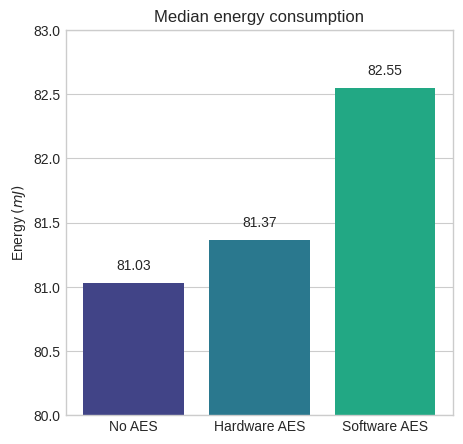

In [102]:
data_files = ["output_no_aes_103", "output_hardware_aes_106", "output_software_aes_127"]
labels = ["No AES", "Hardware AES", "Software AES"]

cumulative_postfix = "_cumulative_values"
step_postfix = "_total_values"

start = 1
end = 100
interval = slice(start, end)
data = "total_energy_mJ"

""" # plot the cumulative total charge consumption
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# [axs[:,0], axs[:,1]]
for data_file, label in zip(data_files, labels):
    # df = pl.read_csv(data_file + cumulative_prefix + ".csv")
    df = pl.read_csv(data_file + step_prefix + ".csv")
    # print(df[data][interval])
    # ax.plot(df["time"][interval] / TICKS_PER_SECOND, df[data][interval], label=label)
    ax.plot(list(range(start, end)), df[data][interval], label=label)
ax.set_xticks(np.arange(0, end+10, 10))
ax.set_xticklabels([f"{x * 10}" for x in ax.get_xticks()])
ax.set_xlim(start, end)
ax.set_title(r"Energy consumption vs $n$")
ax.set_xlabel(r"Transmission $n$")
ax.set_ylabel(r"Total charge $(mJ)$")
ax.grid()

# save fig as pdf
fig.savefig(fig_dir + "pdf/energy_vs_time_consumption.pdf", bbox_inches="tight")
# save fig as png
fig.savefig(fig_dir + "png/energy_vs_time_consumption.png", bbox_inches="tight", dpi=300) """

# # plot the cumulative total energy consumption
# for data_file, label in zip(data_files, labels):
#     df = pl.read_csv(data_file)

#     ax2.plot(df["time"], df["total_energy_mJ"], label=label, marker="o")

# ax2.set_title("Cumulative total energy consumption")
# ax2.set_xlabel("Time (s)")
# ax2.set_ylabel("Total energy (mJ)")
# ax2.grid()

""" # box plot for the total charge consumption datapoints
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) """

# [axs[:,0], axs[:,1]]
# for i, (data_file, label) in enumerate(zip(data_files, labels)):
df_no = pl.read_csv(data_files[0] + step_postfix + ".csv")
df_hardware = pl.read_csv(data_files[1] + step_postfix + ".csv")
df_software = pl.read_csv(data_files[2] + step_postfix + ".csv")

# print means, medians and std for the total charge consumption
print(f"No AES: mean = {df_no[data].mean():.2f} mJ, median = {df_no[data].median():.2f} mJ, std = {df_no[data].std():.2f} mJ")
print(f"Hardware AES: mean = {df_hardware[data].mean():.2f} mJ, median = {df_hardware[data].median():.2f} mJ, std = {df_hardware[data].std():.2f} mJ")
print(f"Software AES: mean = {df_software[data].mean():.2f} mJ, median = {df_software[data].median():.2f} mJ, std = {df_software[data].std():.2f} mJ")

# plot bar plot with median energy consumption
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
y = [df_no[data].median(), df_hardware[data].median(), df_software[data].median()]
ax.bar(labels, y, color=get_colors(3))
ax.set_title("Median energy consumption")
ax.set_ylabel(r"Energy $(mJ)$")
# ax.yaxis.grid()
# ax.grid()
ax.xaxis.grid(False)
ax.set_axisbelow(True)
ax.set_ylim(80, 83)

# print the value on top of the bars
for i, v in enumerate(y):
    ax.text(i, v + 0.1, f"{v:.2f}", ha="center")

""" width = 0.8
bplot = ax.boxplot(
    [df_no[data][start:], df_hardware[data][interval], df_software[data][interval]],
    labels=labels,
    widths=[width for _ in range(len(data_files))],
    patch_artist=True
)

# set colors for the boxplot
for patch, color in zip(bplot["boxes"], ["lightblue", "lightgreen"]):
    patch.set_facecolor(color)

ax.set_title("Total energy consumption")
ax.set_ylabel(r"Total energy $(mJ)$")
ax.yaxis.grid(True) """

# save fig as pdf
fig.savefig(fig_dir + "pdf/total_energy_consumption.pdf", bbox_inches="tight")
# save fig as png
fig.savefig(fig_dir + "png/total_energy_consumption.png", bbox_inches="tight", dpi=300)

0.2


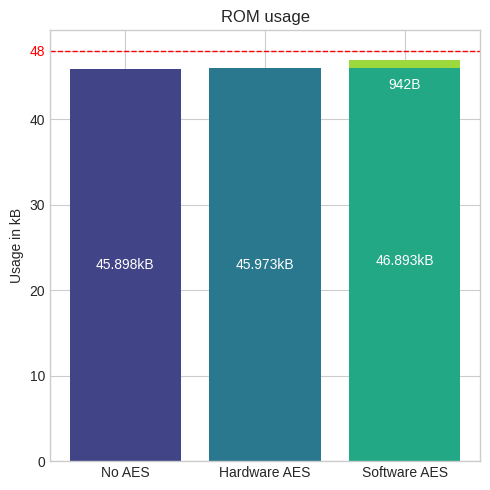

In [116]:
# there is 48kB of ROM
total_space_bytes = 48 * 1024
no_aes_bytes = 47000
hardware_aes_bytes = 47076
software_aes_bytes = 48018

# plot as a bar chart
# kB unit on y axis
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(
    ["No AES", "Hardware AES", "Software AES"],
    [no_aes_bytes / 1024, hardware_aes_bytes / 1024, software_aes_bytes / 1024],
    color=get_colors(3)
)
ax.set_ylabel("Usage in kB")
ax.set_title("ROM usage")
# print the value for Software and Hardware AES on the bar
for i, v in enumerate([no_aes_bytes / 1024, hardware_aes_bytes / 1024, software_aes_bytes / 1024]):
    ax.text(i, v/2, f"{v:.3f}kB", ha="center", va="center", color="white")

# the ticks
limit_color = "red"
ax.axhline(y=total_space_bytes / 1024, color=limit_color, linestyle="--", linewidth=1)
ax.set_yticks(list(range(0, 50, 10)) + [total_space_bytes / 1024])
ax.get_yticklabels()[-1].set_color(limit_color)

# show difference using hardware AES as baseline, using a different color for the diff bar
diff = software_aes_bytes - hardware_aes_bytes
diff_color = custom_cmap(0.85)
ax.bar(["Software AES"], [diff / 1024], bottom=hardware_aes_bytes / 1024, color=diff_color)
# print the value for the diff on the bar in red
ax.text(2, (hardware_aes_bytes / 1024)-2, f"{diff:.0f}B", ha="center", va="center", color="white")

fig.tight_layout()

# save the figure as pdf and png
fig.savefig(fig_dir + "pdf/rom_usage.pdf")
fig.savefig(fig_dir + "png/rom_usage.png", dpi=300)

plt.show()

No AES: mean = 395.14 ms, median = 397.00 ms, std = 10.08 ms
Hardware AES: mean = 408.64 ms, median = 410.00 ms, std = 10.31 ms
Software AES: mean = 510.88 ms, median = 510.00 ms, std = 10.68 ms
{'No AES': {'mean': 395.135593220339, 'median': 397.0, 'std': 10.081797033651819}, 'Hardware AES': {'mean': 408.64462809917353, 'median': 410.0, 'std': 10.313162178395535}, 'Software AES': {'mean': 510.87820512820514, 'median': 510.0, 'std': 10.682686057065418}}
0.2
0.2


/tmp/ipykernel_58154/3663552337.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick / TICKS_PER_SECOND * 1000:.2f}" for tick in ax.get_yticks()])


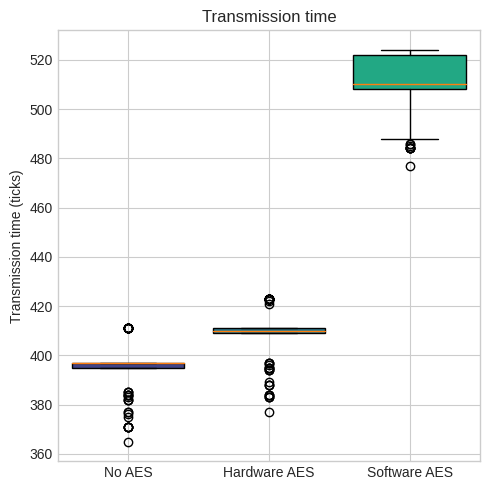

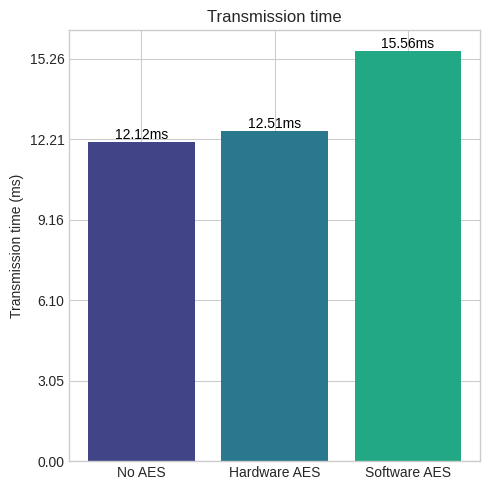

In [27]:
data_files = ["output_no_aes_rtiming_117", "output_hardware_aes_rtiming_120", "output_software_aes_rtiming_155"]
labels = ["No AES", "Hardware AES", "Software AES"]


# from each data file, use regex to find all transmission times
# look for the line that starts with "Transmission time: "
# and extract the number after the colon

# the regex pattern
pattern = re.compile(r"Transmission time: (\d+)")
# the list of transmission times
transmission_times = []

# for each data file
for data_file in data_files:
    # open the file
    with open(data_file + ".txt", "r") as f:
        # read the content
        content = f.read()
        # find all matches
        matches = pattern.findall(content)
        # convert to int
        matches = [int(match) for match in matches]
        # append to the list
        transmission_times.append(matches)

# print(transmission_times)

# load transmission times into polars dataframe
data = dict({
    label: times for label, times in zip(labels, transmission_times)
})
# print(data)


data_desc = dict()
# find and print mean, median and std for each transmission time list, saving the results in a dict
for label, times in data.items():
    mean = np.mean(times)
    median = np.median(times)
    std = np.std(times)
    # insert the results in the dict
    data_desc[label] = dict({
        "mean": mean,
        "median": median,
        "std": std
    })
    print(f"{label}: mean = {mean:.2f} ms, median = {median:.2f} ms, std = {std:.2f} ms")

print(data_desc)

# boxplot for each transmission time list
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
width = 0.8
bplot = ax.boxplot(data.values(), widths=[width for _ in range(len(data))], patch_artist=True)
ax.set_xticklabels(data.keys())
ax.set_ylabel("Transmission time (ticks)")
ax.set_title("Transmission time")

# set colors
for patch, color in zip(bplot["boxes"], get_colors(len(data))):
    patch.set_facecolor(color)

fig.tight_layout()
# save the figure as pdf and png
fig.savefig(fig_dir + "pdf/transmission_time_bplot.pdf")
fig.savefig(fig_dir + "png/transmission_time_bplot.png", dpi=300)

# plot median times as a bar chart
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(
    data_desc.keys(),
    [data_desc[label]["median"] for label in data_desc.keys()],
    color=get_colors(len(data_desc))
)
ax.set_ylabel("Transmission time (ms)")
ax.set_title("Transmission time")

# print the value on top of the bars
for i, v in enumerate([data_desc[label]["median"] for label in data_desc.keys()]):
    ax.text(i, v, f"{v / TICKS_PER_SECOND * 1000:.2f}ms", ha="center", va="bottom", color="black")

# convert y tick labels to ms
ax.set_yticklabels([f"{tick / TICKS_PER_SECOND * 1000:.2f}" for tick in ax.get_yticks()])

fig.tight_layout()

# save the figure as pdf and png
fig.savefig(fig_dir + "pdf/transmission_time_bar.pdf")
fig.savefig(fig_dir + "png/transmission_time_bar.png", dpi=300)
